# On the use of "triangle plots" in trend analysis 

This is the code used to produce the plots presented here: http://fabienmaussion.info/2016/04/29/trendy-triangles/

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

## Real case: GISS global temperature data 

### Download

Gistemp dataset: http://data.giss.nasa.gov/gistemp/

In [22]:
# This just reads the data from the provided url
import io, requests
url = 'http://data.giss.nasa.gov/gistemp/tabledata_v3/GLB.Ts+dSST.csv'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col=0)

In [23]:
# for today we'll concentrate on annual averages
ts = df['J-D'].loc[1880:2015].astype('float') * 0.01

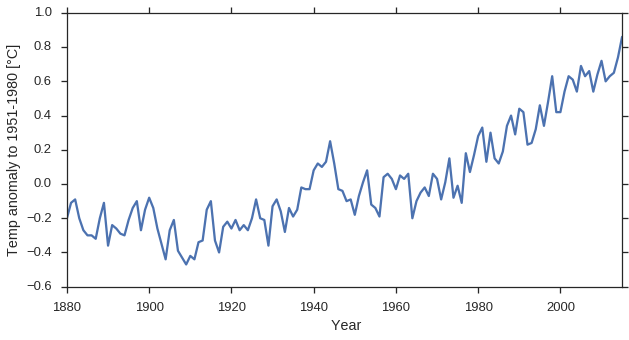

In [24]:
ax = ts.plot(figsize=(9, 5));
ax.set_ylabel('Temp anomaly to 1951-1980 [°C]');
plt.tight_layout()
plt.savefig('ts_giss.png', dpi=150)

### Trend analysis 

In [25]:
# the trend are computed on time series at least 20yrs long
start_years = ts.index[:-20]
end_years = ts.index[20:]
ny = len(start_years)
extent = (start_years[0], start_years[-1], end_years[0], end_years[-1])  # needed for the plot later

In [26]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.zeros((ny, ny)) * np.NaN
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val

### Plot 

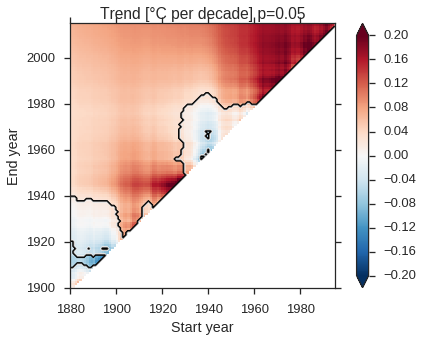

In [27]:
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.2, vmax=0.2)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade] p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
plt.savefig('triangle_giss.png', dpi=150)

In [28]:
print('{:.1%} of the triangle has a significant trend.'.format(np.sum(sig < 0.05) / np.sum(np.isfinite(sig))))

84.1% of the triangle has a significant trend.


## Random case 

We make a fake global temperature timeseries which has the same variance as the real one. We assume normality (which is far from reality...):

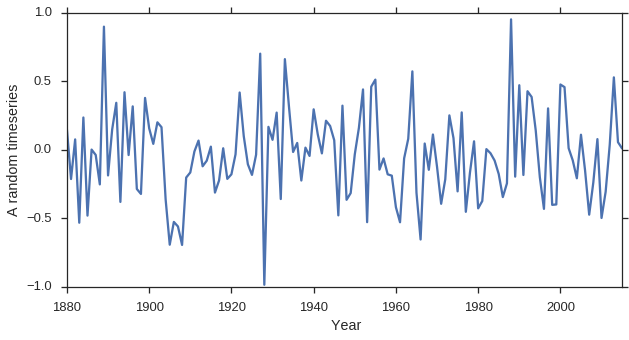

In [29]:
np.random.seed(12)  # for reproducible results
fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
ax = fake_ts.plot(figsize=(9, 5));
ax.set_ylabel('A random timeseries');
plt.tight_layout()
plt.savefig('ts_random.png', dpi=150)

In [30]:
trend = np.zeros((ny, ny)) * np.NaN
sig = np.zeros((ny, ny)) * np.NaN
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = fake_ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val

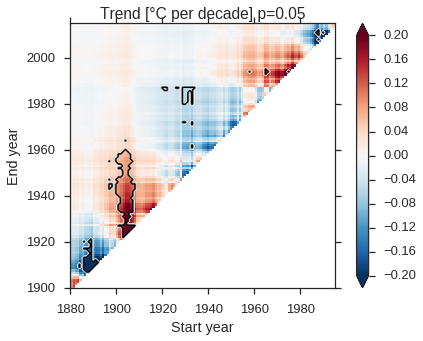

In [31]:
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.2, vmax=0.2)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade] p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
plt.savefig('triangle_random.png', dpi=150)

In [32]:
print('{:.1%} of the triangle has a significant trend.'.format(np.sum(sig < 0.05) / np.sum(np.isfinite(sig))))

4.6% of the triangle has a significant trend.


### "Extreme" example: 

32.4% of the triangle has a significant trend.


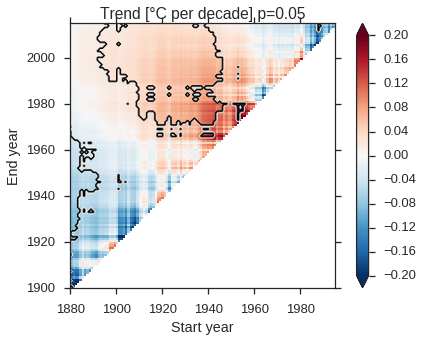

In [33]:
np.random.seed(0)  # for reproducible results
fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
trend = np.zeros((ny, ny)) * np.NaN
sig = np.zeros((ny, ny)) * np.NaN
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = fake_ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.2, vmax=0.2)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade] p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
plt.savefig('triangle_random_ex.png', dpi=150)
print('{:.1%} of the triangle has a significant trend.'.format(np.sum(sig < 0.05) / np.sum(np.isfinite(sig))))

## More systematic case: how often does this extreme case happen? 

We repeat the game a 1000 times and see how many percent of the triangle is "significant".

In [13]:
def get_sig_ratio(in_ts):
    trend = np.zeros((ny, ny)) * np.NaN
    sig = np.zeros((ny, ny)) * np.NaN
    for i, start_year in enumerate(start_years):
        for j, end_year in enumerate(end_years):
            data = in_ts.loc[start_year:end_year]
            if len(data) < 20:
                continue
            slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
            trend[j, i] = slope * 10  # for decadal trends
            sig[j, i] = p_val
    return len(np.nonzero(sig < 0.05)[0]) / np.sum(np.isfinite(trend))

In [14]:
perc = []
np.random.seed(0)  # for reproducible results
# this can take *a while*, obviously
for _ in range(1000):
    fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
    perc.append(get_sig_ratio(fake_ts))

In [36]:
d = {'avg': np.average(perc), 'max': np.max(perc), 'nmore':np.sum(np.array(perc)>0.20)}
print('The average area of the significance is {avg:.1%}, and {nmore} of the 1000 runs have more then 20%.'.format(**d))

The average area of the significance is 4.9%, and 35 of the 1000 runs have more then 20%.


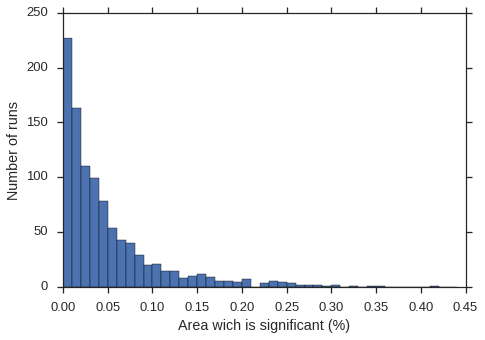

In [34]:
# plot
plt.figure(figsize=(7, 5))
plt.hist(perc, bins=np.arange(45)*0.01);
plt.ylabel('Number of runs')
plt.xlabel('Area wich is significant (%)')
plt.tight_layout()
plt.savefig('hist_real.png', dpi=150)